# AI in Pipeline Engineering

# Summary

This notebook centers on predicting the maximum depth of anomalies in In-Line Inspection (ILI) data. Utilizing various machine learning techniques, the goal is to fill in missing values and forecast the future growth of anomalies. Accurately estimating anomaly depth is critical for assessing pipeline strength and ensuring safety. The process involves data exploration, cleaning, feature engineering, anomaly mapping, and advanced modeling. These steps offer valuable insights for managing pipeline integrity, enabling proactive maintenance and risk mitigation.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models", was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# 1. Introduction

Pipeline integrity management is crucial in ensuring the safety and reliability of gas and oil transportation. In-line inspection (ILI) tools are extensively used to detect and measure anomalies in pipelines. Accurately predicting the maximum depth of these anomalies is essential for proactive maintenance and risk mitigation. This notebook demonstrates a comprehensive workflow, from data loading and cleaning to advanced machine learning modeling, aimed at predicting anomaly depths effectively. Key steps in the process include:

**Data Exploration and Cleaning**: This involves exploratory data analysis (EDA) to understand the data distribution and identify patterns, handling duplicate records, and managing missing values.

**Feature Engineering**: We compute new features such as aspect ratio and area of anomalies, estimate the maximum depth using domain-specific calculations, and create cyclic features from angular measurements.

**Anomaly Mapping**: We match anomalies across different inspection years to track their growth and changes over time. This involves sophisticated matching algorithms to identify corresponding anomalies based on relative distances and orientations.

**Modeling**: We employ machine learning models, particularly the Hist Gradient Boosting Regressor, to predict the maximum depth of anomalies. This includes data preparation, model training, hyperparameter tuning, and evaluation.

**Prediction and Validation**: The predicted values are validated against actual measurements to ensure accuracy. We also compare the machine learning predictions with domain-specific estimates to highlight the added value of advanced modeling techniques.

The ILI data for this study is publicly available from the [Mendeley Data repository](https://data.mendeley.com/datasets/c2h2jf5c54/1). The dataset, titled "Dataset for: Cross-country Pipeline Inspection Data Analysis and Testing of Probabilistic Degradation Models," was published on October 4, 2021, by Rioshar Yarveisy, Faisal Khan, and Rouzbeh Abbassi from Memorial University of Newfoundland and Macquarie University. The dataset includes four consecutive ILI data sets, which lack certain details such as coordinates, likely due to anonymization efforts.

# 2. Setup

## Import Dependencies

In [78]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import importlib
from src import tools
importlib.reload(tools)

<module 'src.tools' from 'c:\\Users\\Farhad.Davaripour\\Repositories\\AI_Applications_in_Pipeline_Engineering\\src\\tools.py'>

In [ ]:
# Set the directory to save and read the data
save_path = "Dataset/processed_data/"

## Loading the ILI Data

In [ ]:
AnomaliesProc  = pd.read_csv(os.path.join(save_path, f'external_anomoly_processed.csv'))

### Rename Columns

In [ ]:
from src.tools import rename_anomaly_columns

# Rename the columns
AnomaliesProc = rename_anomaly_columns(AnomaliesProc)

# 3. EDA

In [ ]:
from src.tools import EDA

**Max Depth (mm)**

In [ ]:
# Create the EDA object
eda = EDA(AnomaliesProc)

In [ ]:
# plot the histogram of the max depth
eda.plot_histogram_max_depth('MaxDepth_mm')

In [ ]:
# Summary statistics
print(AnomaliesProc['MaxDepth_mm'].describe())

In [ ]:
# Calculate the percentiles and IQR
eda.calculate_percentiles_and_iqr('MaxDepth_mm')

In [ ]:
# Plot the boxplot
eda.plot_boxplot_max_depth('MaxDepth_mm')

**Linear Correlation**

In [ ]:
eda.plot_correlation_matrix()

# 4. Data Preprocessing

## 4.1 Duplicate Values

In [ ]:
# Check for duplicate rows
duplicates = AnomaliesProc.duplicated(keep=False)

# Display the duplicate rows
duplicate_rows = AnomaliesProc[duplicates]

# Print the duplicate rows
print("Duplicate rows in the dataframe:")
print(duplicate_rows)

## 4.2 Missing Values

In [ ]:
from src.tools import MissingValuesAnalyzer

# Create the MissingValuesAnalyzer object
MissingValuesAnalyzer = MissingValuesAnalyzer(AnomaliesProc)

**Identify Features w/ Missing Values**

In [ ]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

### 4.2.1 End Point Distance                 

In [ ]:
# Apply the calculation only if the 'EndPointDistance_m' column has NaN values
AnomaliesProc['EndPointDistance_m'] = np.where(
    AnomaliesProc['EndPointDistance_m'].isna(),
    AnomaliesProc['StartPointDistance_m'] + AnomaliesProc['FeatureLength_mm'] / 1000,
    AnomaliesProc['EndPointDistance_m']
)

In [ ]:
# Find the remaining columns with missing values
MissingValuesAnalyzer.find_missing_values()

### 4.2.2 Seam Orientation             

#### 4.2.2.1 Handle Joints with Inconsistent Seam Orientation**

In [ ]:
# Handle joints with inconsistent seam orientation
MissingValuesAnalyzer.check_inconsistent_seam_orientation()

In [ ]:
# Handle joints with inconsistent seam orientation
MissingValuesAnalyzer.handle_inconsistent_seam_orientation()

In [ ]:
# Find and report the inconsistent joints
MissingValuesAnalyzer.find_and_report_inconsistent_joints()

#### 4.2.2.2 Handle Joints with missing Values

**Permutation using Mean**

In [ ]:
# Fill the missing seam orientation values with the average. Since each joints has a unique seam orientation, the average is the same as the original value.
AnomaliesProc = MissingValuesAnalyzer.fill_missing_seam_orientation_w_average()

In [ ]:
# Find columns with missing values. The remaining missing values occurs in joints with no seam orientation across all inspection years. For those, we can use fill forward from the previous joint.
MissingValuesAnalyzer.find_missing_values()

**Permutation using Fill Forward**

In [ ]:
# Fill the missing seam orientation values with the previous value
AnomaliesProc =  MissingValuesAnalyzer.fill_missing_seam_orientation_w_ffill()

In [ ]:
# Find columns with missing values
MissingValuesAnalyzer.find_missing_values()

## 4.3 Outlier Removal

In [ ]:
from src.tools import HandlingOutlier

# Example usage
handling_outlier_columns = ['MaxDepth_mm', 'FeatureWidth_mm', 'FeatureLength_mm', 'InspectionYear']

# Create an instance of the HandlingOutlier class
outlier_handler = HandlingOutlier(DPrev_Old_Filtered_Anomaly_mapped_df)

# Remove outliers using Z-score method
DPrev_Old_Filtered_Anomaly_mapped_df = outlier_handler.remove_outliers_zscore(handling_outlier_columns)

# Remove outliers using Isolation Forest method
DPrev_Old_Filtered_Anomaly_mapped_df = outlier_handler.remove_outliers_isolation_forest(handling_outlier_columns)

# 5. Feature Engineering

**Predicting Anomaly Depth: A Machine Learning Approach**
This exercise aims to predict the maximum depth of anomalies for educational purposes. The applications of this prediction include filling in missing data and forecasting the future growth of anomalies, particularly the maximum depth.

### 5.1 Setup

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt.callbacks import DeltaYStopper

In [ ]:
# Make a copy of the DataFrame
AnomaliesProc_ML_Ready = AnomaliesProc.copy()

### 5.2 Data Manipulation (Optional)
Random removal of MaxDepth data to then predict them using ML for educational purposes.

In [ ]:
# Randomly remove 5% of the values from MaxDepth_mm column
# mask = np.random.rand(len(AnomaliesProc)) < 0.01  # Adjusted to 1%
# AnomaliesProc.loc[mask, 'MaxDepth_mm'] = np.nan

# Verify the number of missing values
# print(f"Number of missing values: {AnomaliesProc['MaxDepth_mm'].isnull().sum()}")

We skip the model selection and hyperparameter tuning step and use Hist Gradient Boosting Regressor with default hyperparameter to predict the records with missing max_depth_mm values.

### 5.3 Anomaly Mapping

**Setup**

In [ ]:
from src.tools import Anomaly_mapping, plot_anomalies_by_year

**Running the Mapping Pipeline**

In [ ]:
# Define the parameters
increment_size = 1000
relative_distance_threshold = 0.1  # meters
orientation_threshold = 10  # degrees

# Create an instance of Anomaly_mapping using AnomaliesProc_ML_Ready
anomaly_mapper = Anomaly_mapping(AnomaliesProc_ML_Ready, relative_distance_threshold, orientation_threshold)

# Call the process_in_increments method and store the result in Anomaly_mapped_df
Anomaly_mapped_df = anomaly_mapper.process_in_increments(save_path, increment_size)

**Plot the anomalies by year**

In [ ]:
# Save the updated DataFrame to a CSV file
Plot_Anomaly_mapped_df_file_path = (os.path.join(save_path, f'Plot_Mapped_Anomalies.csv'))

Anomaly_mapped_df[[
    'GirthWeldNumber',
    'InspectionYear',
    'RelativeDistance_m',
    'Tag',
    'SignificantPointOrientation_deg'
]].to_csv(Plot_Anomaly_mapped_df_file_path, index=False)

In [ ]:
# Plot the anomalies by year
plot_anomalies_by_year(Anomaly_mapped_df, 14, figsize=(15, 3))

### 5.4 Feature Engineering

In [ ]:
from src.tools import FeatureEngineering

# Create an instance of the class with your dataframe
feature_engineering = FeatureEngineering(AnomaliesProc_ML_Ready)

#### 5.4.1 Aspect Ratio and Area

In [ ]:
# Compute the aspect ratio
AnomaliesProc_ML_Ready = feature_engineering.compute_aspect_ratio()

# Calculate the feature area
AnomaliesProc_ML_Ready = feature_engineering.calculate_feature_area()

#### 5.4.2 Radial to Cyclic Features

In [ ]:
# Add the angular features
angle_columns = ['SeamOrientation_deg', 'StartPointOrientation_deg', 'EndPointOrientation_deg', 'SignificantPointOrientation_deg']
AnomaliesProc_ML_Ready = feature_engineering.add_angular_features(angle_columns)

#### 5.4.3 Tag Erroneous Records

In [ ]:
from src.tools import ErroneousAnomalyProcessor

# Load the AnomaliesProc_Mapped_All_GirthWelds.csv file
Anomaly_mapped_df = pd.read_csv(os.path.join(save_path, f'AnomaliesProc_Mapped_All_GirthWelds.csv'))

# Detect errors in mapped anomalies
anomaly_processor = ErroneousAnomalyProcessor(Anomaly_mapped_df)

# Apply the detect_errors method
Anomaly_mapped_df['ErrorClassification'] = Anomaly_mapped_df.apply(
    anomaly_processor.detect_errors, axis=1
)

# Save the updated DataFrame to a CSV file
Anomaly_mapped_validated_df_file_path = (os.path.join(save_path, f'AnomaliesProc_Mapped_All_GirthWelds_Validated.csv'))
Anomaly_mapped_df.to_csv(Anomaly_mapped_validated_df_file_path, index=False)

In [ ]:
# Save the updated DataFrame to a CSV file
Anomaly_mapped_validated_df_file_path = '../Dataset/processed_data/AnomaliesProc_Mapped_All_GirthWelds_Validated.csv'

Anomaly_mapped_df = pd.read_csv(Anomaly_mapped_validated_df_file_path)

In [ ]:
# Print error statistics
ErroneousAnomalyProcessor.print_error_statistics()

**Filter Anomalies**

In [ ]:
# Filter the DataFrame to include only the 'Okay' records
Filtered_Anomaly_mapped_df = Anomaly_mapped_df[Anomaly_mapped_df.ErrorClassification == 'Okay']

# Filter the DataFrame to include only the 'old' and 'new' records
Old_Filtered_Anomaly_mapped_df = Filtered_Anomaly_mapped_df[Filtered_Anomaly_mapped_df.Tag == 'old']
New_Filtered_Anomaly_mapped_df = Filtered_Anomaly_mapped_df[Filtered_Anomaly_mapped_df.Tag == 'new']

In [ ]:
# Save the updated DataFrame to a CSV file
Old_Filtered_Anomaly_mapped_df_file_path = (os.path.join(save_path, f'Old_Filtered_Anomaly_mapped_df.csv'))
Old_Filtered_Anomaly_mapped_df.to_csv(Old_Filtered_Anomaly_mapped_df_file_path, index=False)

#### 5.4.4 Include Second Prior Inspection Data

In [ ]:
from src.tools import add_dprev_features

# Add the secont previous inspection year features to the DataFrame
DPrev_Old_Filtered_Anomaly_mapped_df = add_dprev_features(Old_Filtered_Anomaly_mapped_df)

In [74]:
# Define the file path to store the updated DataFrame
DPrev_Old_Filtered_Anomaly_mapped_df_file_path = (os.path.join(save_path, f'DPrev_Old_Filtered_Anomaly_mapped_df.csv'))

In [ ]:
# Save the updated DataFrame to a CSV file
DPrev_Old_Filtered_Anomaly_mapped_df.to_csv(DPrev_Old_Filtered_Anomaly_mapped_df_file_path, index=False)

In [75]:
# Load the updated DataFrame from the CSV file
DPrev_Old_Filtered_Anomaly_mapped_df = pd.read_csv(DPrev_Old_Filtered_Anomaly_mapped_df_file_path)
DPrev_Old_Filtered_Anomaly_mapped_df.dropna(inplace=True)

#### 5.4.5 Encoding Anomaly Cluster

In [79]:
from src.tools import AnomalyClusterer

In [80]:
# List of features to be used for clustering
clustering_features = [
    'RelativeDistance_m',
    'FeatureLength_mm',
    'FeatureWidth_mm',
    'MaxDepth_mm',
    'SignificantPointOrientation_deg',
    'Prev_RelativeDistance_m',
    'Prev_FeatureLength_mm',
    'Prev_FeatureWidth_mm',
    'Prev_MaxDepth_mm',
    'Prev_SignificantPointOrientation_deg',
    'JointLength_m',
    'SeamOrientation_deg',
    'StartPointDistance_m',
    'StartPointOrientation_deg',
    'EndPointDistance_m',
    'EndPointOrientation_deg',
    'SignificantPointRelDistance_m',
    'WallThickness_mm',
    'AspectRatio',
    'FeatureArea_mm2',
    'estimated_max_depth_mm'
]

In [81]:
clusterer = AnomalyClusterer(DPrev_Old_Filtered_Anomaly_mapped_df, clustering_features)
DPrev_Old_Filtered_Anomaly_mapped_df = clusterer.perform_clustering()

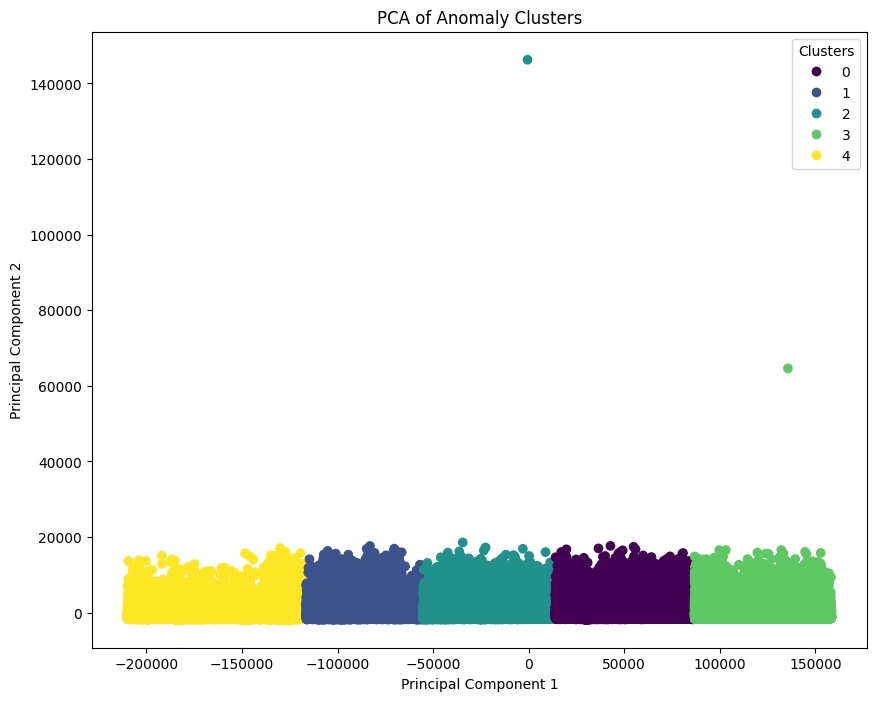

In [82]:
clusterer.visualize_clusters()

### 5.5 Class Imbalance

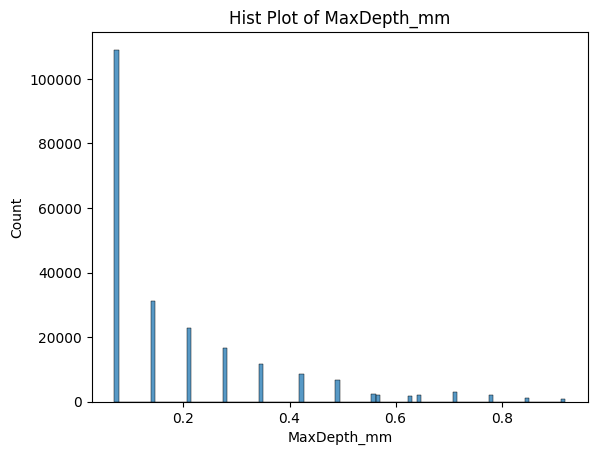

In [85]:
# class_counts = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'].value_counts().sort_index()
sns.histplot(DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm'], bins=100)
plt.title('Hist Plot of MaxDepth_mm')
plt.xlabel('MaxDepth_mm')
plt.ylabel('Count')
plt.show()

### 5.6 Feature Importance

Lasso regularization algorithm is used for to identify feature importance.

**Processing Features**

In [89]:
# Define features and target
features = DPrev_Old_Filtered_Anomaly_mapped_df.drop(
    columns=[
        'MaxDepth_mm',
        'Tag',
        'ErrorClassification',
        'DepthChange'
    ]
)

target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

Standardization of features is done.
Data splitting into training and testing sets is done.
Grid search is done. Best alpha value: 0.001
Fitting the Lasso model with the best alpha is done.
Calculation of feature coefficients is done.


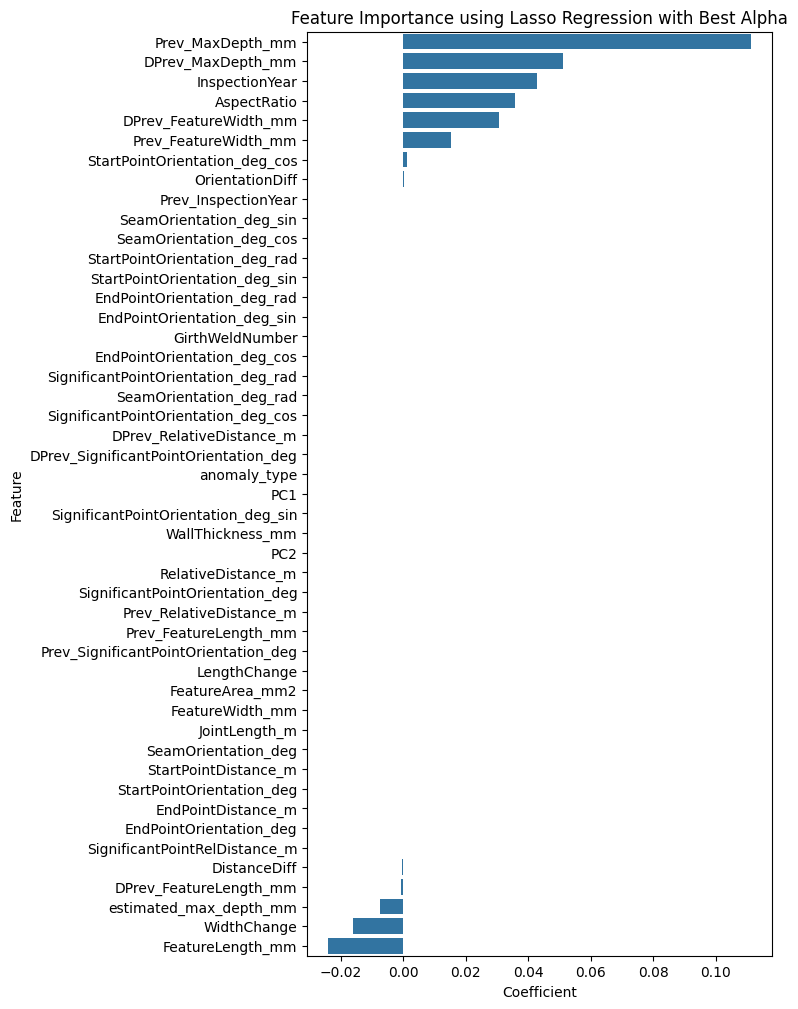

Plotting of coefficients is done.


In [90]:
from src.tools import FeatureImportance

feature_importance = FeatureImportance(features, target)

# Perform the steps
feature_importance.standardize_features()
feature_importance.split_data()
feature_importance.perform_grid_search()
feature_importance.fit_best_lasso()
feature_importance.calculate_coefficients()

# Plot the coefficients
feature_importance.plot_coefficients()

# 6. Training

## 6.1 Features w/ Missing Values

In [100]:
# Apply the mask to remove outliers only from the target variable
target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

# Keep all features, including rows where target is an outlier
features = DPrev_Old_Filtered_Anomaly_mapped_df[[
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'FeatureLength_mm',
        'FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'AspectRatio',
        'FeatureArea_mm2',
        'estimated_max_depth_mm',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos',
        'LengthChange',
        'WidthChange',
        'DistanceDiff',
        'OrientationDiff',
    ]]

### 6.1.1 Training Pipeline and Evaluation

In [101]:
from src.tools import TrainingPipeline

# Create an instance of the TrainingPipeline class
ML_pipeline = TrainingPipeline(features, target)
print("Pipeline instance created")

# Scale the features
ML_pipeline.scale_features()
print("Features scaled")

# Split the data
ML_pipeline.split_data(handle_imbalance=True)
print("Data split")

# Perform hyperparameter tuning and return the best parameters
best_params = ML_pipeline.hyperparameter_tuning()
print("Best parameters found:")
print(best_params)

# Fit the model using the best hyper parameters
ML_pipeline.fit_model()
print("Model fitted")

# Evaluate the model and print the metrics
evaluation_metrics = ML_pipeline.evaluate_model()
for metrics,performance in evaluation_metrics.items():
    print(f"{metrics}: {performance}")

Pipeline instance created
Features scaled
Data split
Best parameters found:
OrderedDict([('l2_regularization', 0.0015783879853890563), ('learning_rate', 0.055487920443684), ('max_depth', 7), ('max_iter', 386), ('min_samples_leaf', 46)])
Model fitted
RMSE: 0.10737450054201335
MAE: 0.07823228088750447
R2: 0.7883142004481365
MAPE: 28.846156760827135
ME: 0.00042466347371871344


### 6.1.2 Model Performance Visualization

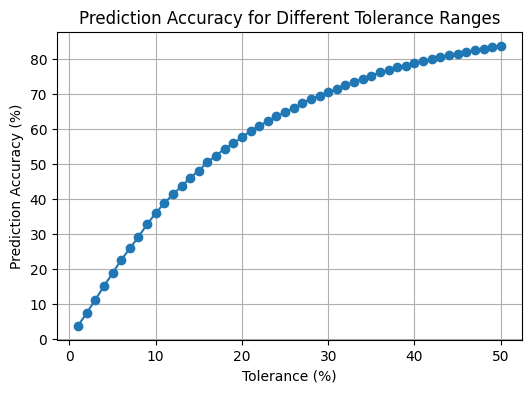

In [102]:
# Plotting results and evaluating prediction accuracy
results = ML_pipeline.plot_prediction_accuracy()

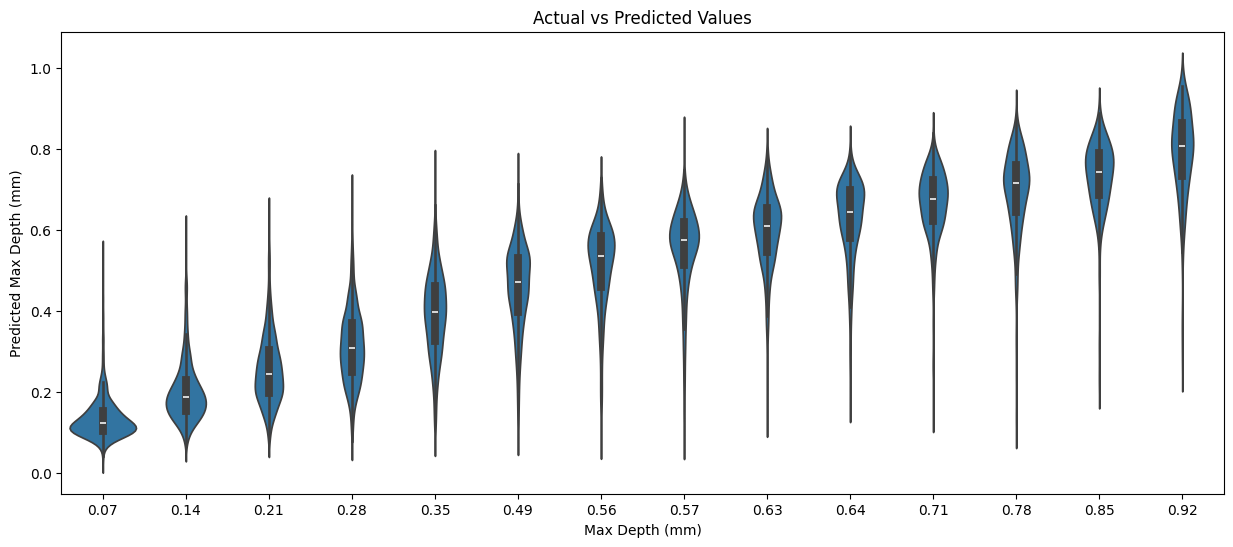

In [98]:
ML_pipeline.plot_violin(results)

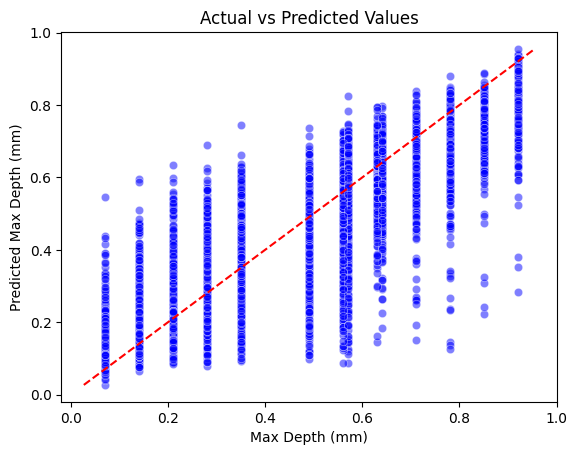

In [99]:
ML_pipeline.plot_scatter(results)

In [ ]:
# Filling missing values
predicted_records = ML_pipeline.fill_missing_values(dataframe=AnomaliesProc_ML_Ready, feature_columns=features.columns, target_column='MaxDepth_mm')
print(predicted_records)

## 6.2 Anomaly Growth

### 6.2.1 Additional Feature Engineering

In [ ]:
DPrev_Old_Filtered_Anomaly_mapped_df['Estimated_FeatureLength_mm'] = 2 * DPrev_Old_Filtered_Anomaly_mapped_df['Prev_FeatureLength_mm'] \
                                                                       - DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureLength_mm']

DPrev_Old_Filtered_Anomaly_mapped_df['Estimated_FeatureWidth_mm'] = 2 * DPrev_Old_Filtered_Anomaly_mapped_df['Prev_FeatureWidth_mm'] \
                                                                        - DPrev_Old_Filtered_Anomaly_mapped_df['DPrev_FeatureWidth_mm']

DPrev_Old_Filtered_Anomaly_mapped_df['Powered_Prev_MaxDepth_mm'] = DPrev_Old_Filtered_Anomaly_mapped_df['Prev_MaxDepth_mm'] ** 2

### 6.2.2 Training and Evaluation Pipeline

In [ ]:
# Apply the mask to remove outliers only from the target variable
target = DPrev_Old_Filtered_Anomaly_mapped_df['MaxDepth_mm']

# Define the list of features
feature_columns = [
        'GirthWeldNumber',
        'InspectionYear',
        'RelativeDistance_m',
        'Estimated_FeatureLength_mm',
        'Estimated_FeatureWidth_mm',
        'SignificantPointOrientation_deg',
        'Prev_InspectionYear',
        'Prev_RelativeDistance_m',
        'Prev_FeatureLength_mm',
        'Prev_FeatureWidth_mm',
        'Prev_MaxDepth_mm',
        'Powered_Prev_MaxDepth_mm',
        'Prev_SignificantPointOrientation_deg',
        'DPrev_RelativeDistance_m',
        'DPrev_FeatureLength_mm',
        'DPrev_FeatureWidth_mm',
        'DPrev_MaxDepth_mm',
        'DPrev_SignificantPointOrientation_deg',
        'SignificantPointOrientation_deg_sin',
        'SignificantPointOrientation_deg_cos'
    ]

# Keep all features, including rows where target is an outlier
features = DPrev_Old_Filtered_Anomaly_mapped_df[feature_columns]

# Ensure features and target have the same index
features = features.loc[target.index]

In [ ]:
from src.tools import TrainingPipeline

# Create an instance of the TrainingPipeline class
ML_pipeline = TrainingPipeline(features, target)
print("Pipeline instance created")

# Scale the features
ML_pipeline.scale_features()
print("Features scaled")

# Split the data
ML_pipeline.split_data(handle_imbalance=True)
print("Data split")

# Perform hyperparameter tuning and return the best parameters
best_params = ML_pipeline.hyperparameter_tuning()
print("Best parameters found:")
print(best_params)

# Fit the model using the best hyper parameters
ML_pipeline.fit_model()
print("Model fitted")

# Evaluate the model and print the metrics
evaluation_metrics = ML_pipeline.evaluate_model()
for metrics,performance in evaluation_metrics.items():
    print(f"{metrics}: {performance}")

### 6.2.3 Visualizing Model Performance

In [ ]:
results = ML_pipeline.plot_prediction_accuracy()

In [ ]:
ML_pipeline.plot_violin(results)

In [ ]:
ML_pipeline.plot_scatter(results)